<h1><center><font size="6">Classification</font></center></h1>



In your second homework you need to create a model that predicts which passengers survived the Titanic shipwreck.

In [101]:
import pandas as pd
import numpy as np
import datetime
import sys
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics

In [102]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

# <a id='3'>Data exploration</a>  

We check the shape of train and test dataframes and also show a selection of rows, to have an initial understanding of the data.



In [103]:
train_df.sample(5).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
754,755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,220845,65.0000,NaN,S
363,364,0,3,"Asim, Mr. Adola",male,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
411,412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.0000,NaN,S
582,583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S


In [104]:
test_df.sample(5).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
163,1055,3,"Pearce, Mr. Ernest",male,NaN,0,0,343271,7.0000,NaN,S
366,1258,3,"Caram, Mr. Joseph",male,NaN,1,0,2689,14.4583,NaN,C
399,1291,3,"Conlon, Mr. Thomas Henry",male,31.0,0,0,21332,7.7333,NaN,Q
199,1091,3,"Rasmussen, Mrs. (Lena Jacobsen Solvang)",female,NaN,0,0,65305,8.1125,NaN,S
263,1155,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S


In [105]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))
print("Test:  rows:{} cols:{}".format(test_df.shape[0], test_df.shape[1]))

Train: rows:891 cols:12
Test:  rows:418 cols:11


Both **train** and **test** files contains the following values:  

* **PassengerID** - the index of the passenger (in the dataset);  
* **PClass** - the class of the passenger (from 1 to 3);
* **Name** - the name of the passenger;
* **Sex** - the sex of the passenger (female or male);  
* **Age** - the age (where available) of the passenger;  
* **SibSp** - the number of sibilings / spouses aboard of Titanic;  
* **Parch** - the number of parents / children aboard of Titanic;  
* **Ticket** - the ticket number;  
* **Fare** - the passenger fare (ticket cost);  
* **Cabin** - the cabin number;  
* **Embarked** - the place of embarcation of the passenger (C = Cherbourg, Q = Queenstown, S = Southampton).  

The **train** data has as well the target value, **Survived**.

It is important to have a good understanding of the data before going to create a model. Therefore we will explore the features.

Let's start by checking if there are missing data and unlabeled data.

Next, analyze the dependencies of the target variable on various features, such as Age, Sex, and so on, using approaches similar to those in the first homework.

Draw conclusions about what affects whether the passenger survives, check the distribution of features in the train and test data. 

In [106]:
import seaborn as sns
import math

#Check which columns have missing data
column_fill_percentage = train_df.isnull().mean().round(4).mul(100).sort_values(ascending=False)
print("How much percent of each columns do have valid values?")
print(column_fill_percentage)

How much percent of each columns do have valid values?
Cabin          77.10
Age            19.87
Embarked        0.22
PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
dtype: float64


In [107]:
# How many people survived in total?
survival_rate = train_df['Survived'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print("How many people survived?")
print(survival_rate)

How many people survived?
Survived
0    61.6%
1    38.4%
Name: proportion, dtype: object


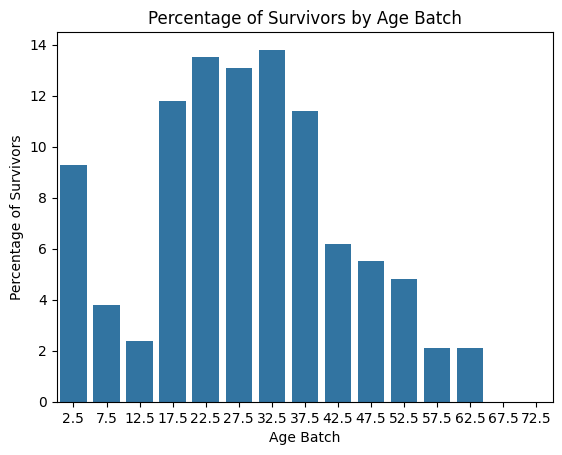

In [108]:
# Children vs Adults vs old people
def plot_survivorship_by_age_batches(file_path): # DO THIS BEFORE NORMALIZING THE AGES (filling gap values with median)
   # Read the CSV file into a DataFrame
   df = pd.read_csv(file_path)

   # Round up the maximum age to the nearest whole number
   max_age = math.ceil(df['Age'].max())

   # Define the bins
   bins = range(0, max_age, 5)
   df['Age Batch'] = pd.cut(df['Age'], bins=bins, right=False)

   df_survived = df[df['Survived'] == 1]

   # Convert the interval index to a regular index
   proportions = df_survived['Age Batch'].value_counts(normalize=True).mul(100).round(1)
   proportions.index = np.array([i.mid for i in proportions.index])

   # Create the bar plot
   ax = sns.barplot(x=proportions.index, y=proportions.values)

   # Set the title and labels
   plt.title('Percentage of Survivors by Age Batch')
   plt.xlabel('Age Batch')
   plt.ylabel('Percentage of Survivors')

   # Display the plot
   plt.show()



plot_survivorship_by_age_batches("train.csv")

In [109]:
### CLEAN UP DATA BEFORE RUNNING MODEL
# Let's check what we have to normalize/throw out
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [110]:
# What do we see above?
# 1) A lot of columns to drop (because irrelevant
# 2) Sex is not numeric
# 3) Some ages are missing (= 'nan')

In [111]:

# Make sex numeric
train_df['Sex'].replace(['female','male'],[0,1], inplace=True)

#remove non-numeric values (also apply common sense, e.g. the Cabin number can't be classified. We don't have a map of the ship)
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis='columns')

# We know that age is empty quite often. Let's fill it with the mean of ages.
inputs.Age.fillna(inputs.Age.mean(), inplace=True)
inputs.Age[:10]

0    22.000000
1    38.000000
2    26.000000
3    35.000000
4    35.000000
5    29.699118
6    54.000000
7     2.000000
8    27.000000
9    14.000000
Name: Age, dtype: float64

In [112]:
# Much better now:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500
5,0,3,1,NaN,0,0,8.4583
6,0,1,1,54.0,0,0,51.8625
7,0,3,1,2.0,3,1,21.0750
8,1,3,0,27.0,0,2,11.1333
9,1,2,0,14.0,1,0,30.0708


*Example:*
From the total female passengers, *n*% survived.  
In the same time, from the total male passengers, only m% survived.


## <a id='50'>Split the data</a>  

Let's split the training and validation set. We will use a 80-20 split. Don't forget to fix random_state. 


In [113]:
# In decision tree classification we drop the labled output from the main datasaet and save it as a target (for preticting future value)
inputs = train_df.drop('Survived', axis='columns')
target = train_df.Survived

# We split and set a random state, so that we get the same split every time we run this code
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=42)


## <a id='51'>Build a model</a>  

We will start with a simple model (baseline), with just two features, the `Sex` and `Pclass`. Create DesicionTreeClassifier and RandomForestClassifier, based on this features, without tuning parameters. 

Next, create two more complicated models: DesicionTreeClassifier and RandomForestClassifier with adding at least one feature you found useful as a result of your analysis.

Find accuracy score for all models. Is it a good idea to use accuracy? Any suggestions about metrics? 

Then try to tune at least one parameter for every model using grid search and write down features and parameters, which gave you best score. 

In [114]:
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [115]:
# Train the model
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [116]:
# Check how good the model works (compare to test data)
model.score(X_test, y_test)

0.7877094972067039

In [117]:
#TUTORIAL: https://www.youtube.com/watch?v=MqhrwP96nMQ